<a href="https://colab.research.google.com/github/pranjul6386/covid_real_time_kaggle/blob/master/reserach_mask_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/My Drive/kaggle_notebooks/mask.zip"

In [2]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
import cv2
import random as rand
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [3]:
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0
#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [4]:
imgs = list(sorted(os.listdir("/content/images")))
len(imgs)

853

In [5]:
labels = list(sorted(os.listdir("/content/annotations")))

In [6]:
len(labels)

853

In [7]:
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/content/images/", file_image)
    label_path = os.path.join("/content/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [8]:
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"/content/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [9]:
face_images.shape

(4072, 224, 224, 3)

In [10]:
face_labels = np.reshape(face_labels,(4072,1))

In [46]:
from sklearn.preprocessing import OneHotEncoder
en=OneHotEncoder()
labels1=en.fit_transform(face_labels)

In [47]:
labels1.shape

(4072, 3)

In [12]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels,3)
labels

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [13]:
labels.shape

(4072, 3)

In [14]:
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [15]:

INIT_LR = 1e-4
EPOCHS = 25
BS = 32

In [16]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),input_shape=(224,224,3),activation="relu",))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(5,5),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(3,activation="softmax"))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 220, 220, 128)     9728      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 128)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 128)     512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 106, 106, 64)      204864    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 51, 51, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)       

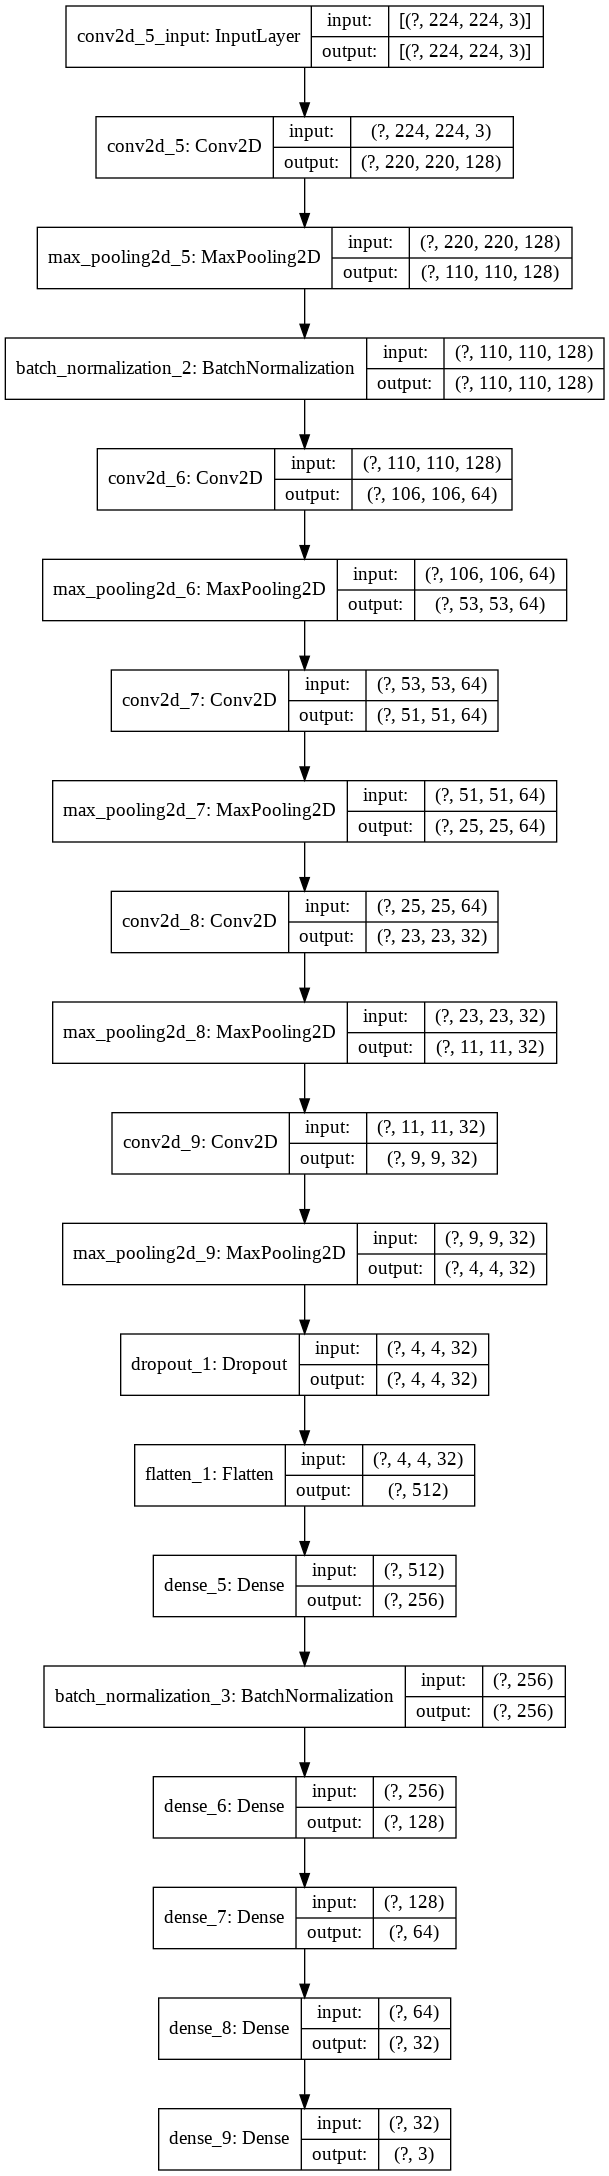

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
print(trainX.shape)

(3257, 224, 224, 3)


In [20]:
print(trainY.shape)

(3257, 3)


In [24]:
filepath="/content/weights.h5"
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
callbacks_list=[earlystop,checkpoint]

In [25]:
import time
start_time=time.time()
history = model.fit(
	trainX, trainY, batch_size=BS,
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS, callbacks=callbacks_list)
total_time=(time.time()-start_time)

Epoch 1/25
101/101 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.8150 
Epoch 00001: val_loss improved from inf to 0.37013, saving model to /content/weights.h5
101/101 [==============================] - 1529s 15s/step - loss: 0.6271 - accuracy: 0.8150 - val_loss: 0.3701 - val_accuracy: 0.8913
Epoch 2/25
101/101 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9240 
Epoch 00002: val_loss improved from 0.37013 to 0.29264, saving model to /content/weights.h5
101/101 [==============================] - 1522s 15s/step - loss: 0.2736 - accuracy: 0.9240 - val_loss: 0.2926 - val_accuracy: 0.9062
Epoch 3/25
101/101 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9355 
Epoch 00003: val_loss did not improve from 0.29264
101/101 [==============================] - 1522s 15s/step - loss: 0.2213 - accuracy: 0.9355 - val_loss: 0.3077 - val_accuracy: 0.8975
Epoch 4/25
101/101 [==============================] - ETA: 0s - loss: 0.2104

In [28]:
total_time

13784.96191906929

In [27]:
_, train_acc = model.evaluate(trainX,trainY, verbose=0)
_, test_acc = model.evaluate(testX,testY, verbose=0)

In [29]:
print(train_acc)
print(test_acc)

0.9487258195877075
0.9349693059921265


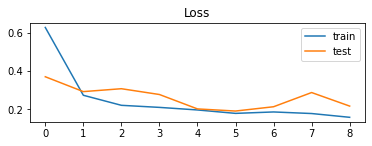

In [30]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

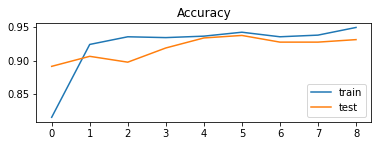

In [31]:
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       143
           1       0.95      0.97      0.96       647
           2       1.00      0.08      0.15        25

    accuracy                           0.93       815
   macro avg       0.94      0.66      0.67       815
weighted avg       0.94      0.93      0.92       815



ValueError: ignored

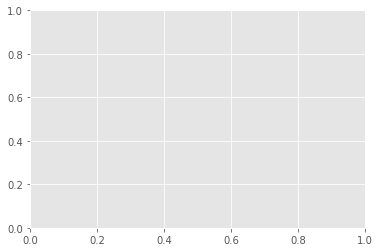

In [36]:
# plot the training loss and accuracy
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [34]:
yhat_classes = model.predict_classes(testX, verbose=0)
yhat_probs = model.predict(testX, verbose=0)

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
accuracy = accuracy_score(testY,yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(testY, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testY, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testY, yhat_classes)
print(matrix)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


IndexError: ignored